# Homework #6: Decision Trees and Random Forests

A bank is interested in reaching out to customers directly (via phone) to solicit subscriptions to a new product they are planning to offer. The company has over 45k customers and only a small number of phone agents to contact them so targeting those that are most likely to subscribe will maximize their return on investment.

Prior to contacting them, they have asked their Data Science team to analyze customer characteristics for a similar product campaign they ran in the previous year. Your goal is to construct an effective tree-based model to predict whether a customer will subscribe or not.

### Relevant Dataset
`bank-full.csv`
* Response Variable: `y`

### Source of data: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing#

## Task 1: Import data and construct a random 70/15/15 train/val/test split. Make sure to dummy code categorical variables.

In [7]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.inspection import PartialDependenceDisplay

In [8]:
# Import dataframe and view head
df = pd.read_csv('bank-full.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [9]:
# Dummy code categorical variables
month_to_number = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
df['month'] = df['month'].map(month_to_number)
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# View head
df.head()

,age,balance,day,month,duration,campaign,pdays,previous,y,job_blue-collar,...,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,5,261,1,-1,0,no,False,...,True,False,False,True,False,False,True,False,False,True
1,44,29,5,5,151,1,-1,0,no,False,...,False,False,False,True,False,False,True,False,False,True
2,33,2,5,5,76,1,-1,0,no,False,...,False,False,False,True,True,False,True,False,False,True
3,47,1506,5,5,92,1,-1,0,no,True,...,False,True,False,True,False,False,True,False,False,True
4,33,1,5,5,198,1,-1,0,no,False,...,False,True,False,False,False,False,True,False,False,True


In [10]:
# Define features and target variable
X = df.drop('y', axis=1)
y = df['y'].map({'yes': 1, 'no': 0})

# Split data into 70% train, 15% validation, and 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print shapes
print(f'Train: {X_train.shape}')
print(f'Test: {X_test.shape}')
print(f'Validate: {X_val.shape}')

Train: (31647, 32)
Test: (6782, 32)
Validate: (6782, 32)


## Task 2: Use Cost-Complexity Pruning to find the optimal depth for a Decision Tree Classifier.

Note: "Optimal" is subjective. Feel free to choose a shallower more interpretable tree or a slightly deeper more accurate tree. Simply explain why you chose the depth you did.

In [12]:
# Try different depths and find the best one
depths = range(1, 21)
best_depth = 0
best_score = 0

for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(tree, X_train, y_train, cv=5, scoring='accuracy')
    avg_score = scores.mean()
    
    if avg_score > best_score:
        best_score = avg_score
        best_depth = depth

print(f'Optimal max_depth: {best_depth}')

# Note: chose the depth above with the best score

Optimal max_depth: 5


## Task 3: Visualize the "Optimal" tree you fit and interpret the first few splits to the best of your ability.

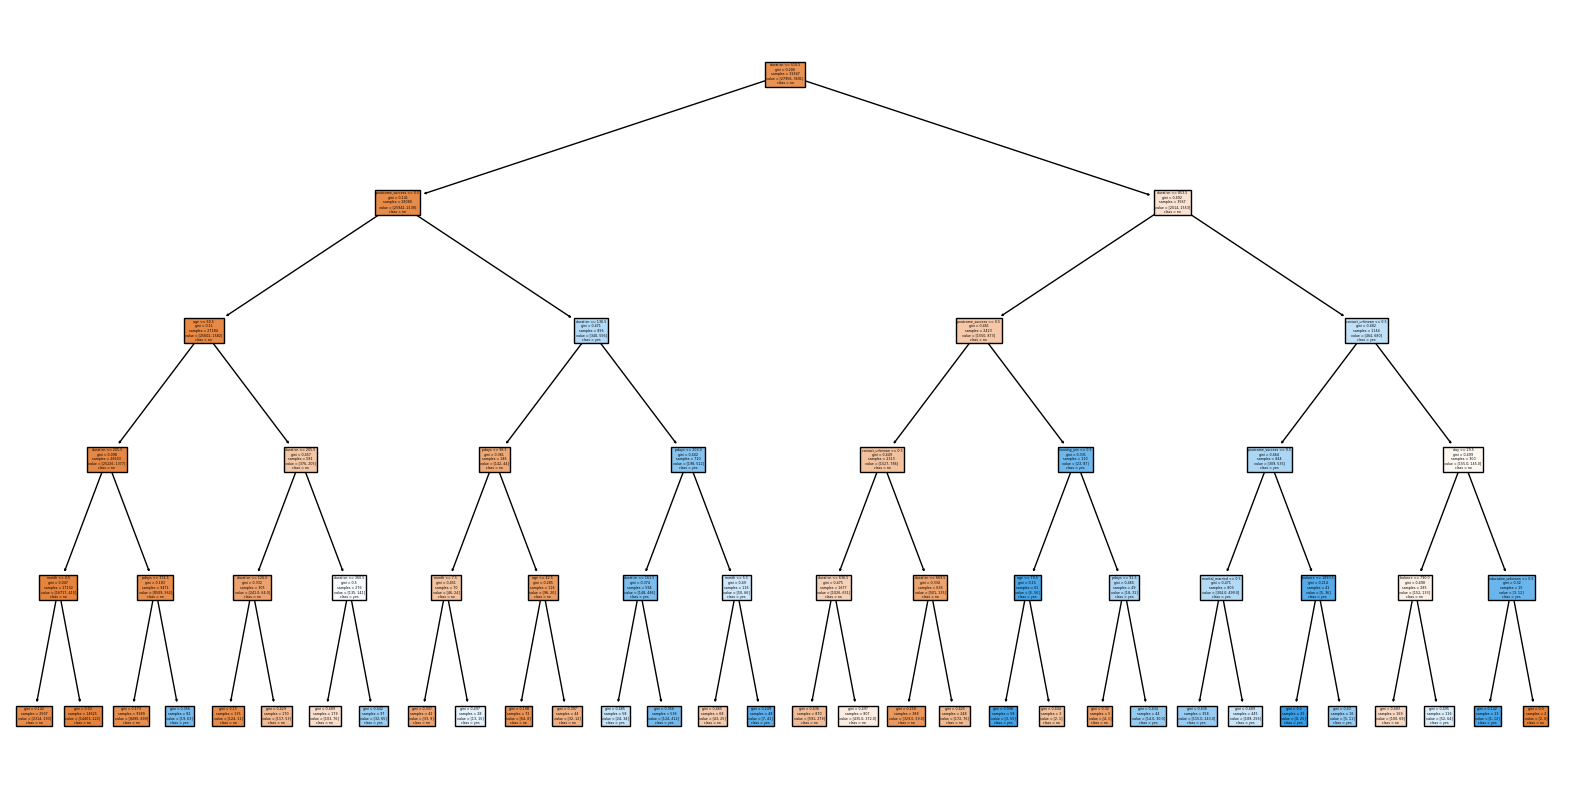

In [14]:
# Fit decision tree with optimal depth
optimal_tree = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
optimal_tree.fit(X_train, y_train)

# Plot decision tree
plt.figure(figsize=(20, 10))
plot_tree(optimal_tree, feature_names=X.columns, class_names=['no', 'yes'], filled=True)
plt.show()

## Task 4: Calculate the k-fold CV accuracy for predicting 'yes' or 'no' using a Decision Tree Classifier.

In [16]:
# Perform k-fold cross-validation for each k values of 5, 10, and 15
k_values = [5, 10, 15]
cv_results = {}

for k in k_values:
    cv_scores = cross_val_score(optimal_tree, X, y, cv=k, scoring='accuracy')
    cv_results[k] = {'mean_accuracy': cv_scores.mean(), 'std_accuracy': cv_scores.std()}

# Find best k
best_k = max(cv_results, key=lambda k: (cv_results[k]['mean_accuracy'], -cv_results[k]['std_accuracy']))
best_accuracy = cv_results[best_k]['mean_accuracy']
best_std = cv_results[best_k]['std_accuracy']

# Print results
print(f'Best k value: {best_k}')
print(f'{best_k} fold mean accuracy: {best_accuracy}')
print(f'{best_k} fold standard deviation: {best_std}')

Best k value: 10
10 fold mean accuracy: 0.8298410112482111
10 fold standard deviation: 0.11352200422057594


## Task 5: Fit a Random Forest Classifier and use the OOB accuracy to choose the optimal number of trees and/or variables sampled at each split.

Note: The argument for number of trees is `n_estimators` in scikit-learn and the number of variables to consider at each split is `max_features`.

In [18]:
# Define random forest model
rf = RandomForestClassifier(oob_score=True, random_state=42)

# Try different values for n_estimators and max_features
n_estimators_options = [50, 100, 200]
max_features_options = ['sqrt', 'log2']
best_n_estimators = 0
best_max_features = ''
best_oob_score = 0

for n_estimators in n_estimators_options:
    for max_features in max_features_options:
        rf.set_params(n_estimators=n_estimators, max_features=max_features)
        rf.fit(X_train, y_train)
        
        if rf.oob_score_ > best_oob_score:
            best_oob_score = rf.oob_score_
            best_n_estimators = n_estimators
            best_max_features = max_features

print(f'Optimal n_estimators: {best_n_estimators}')
print(f'Optimal max_features: {best_max_features}')

Optimal n_estimators: 200
Optimal max_features: sqrt


## Task 6: Report impurity based feature importance for your final selected model in a bar chart. 

Optional: If you are curious, try running permutation importance (note: this may take a while) and compare the two

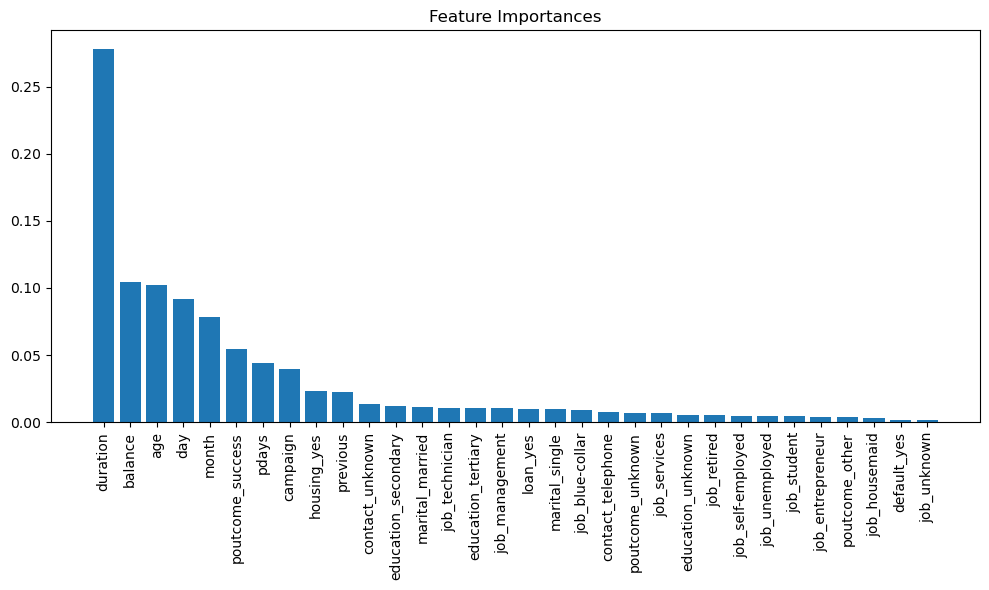

In [20]:
# Fit random forest with the optimal parameters
rf_optimal = RandomForestClassifier(n_estimators=best_n_estimators, max_features=best_max_features, oob_score=True, random_state=42)
rf_optimal.fit(X_train, y_train)

# Plot the feature importances
importances = rf_optimal.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

## Task 7: Choose the model with the best cross-validated or OOB accuracy between Decision Trees and Random Forests and provide the Partial Dependence Plots for the 5 most important variables.

In [22]:
# Get OOB accuracy of random forest
oob_accuracy_rf = rf_optimal.oob_score_
print(f'OOB accuracy of the Random Forest: {oob_accuracy_rf}')

# Compare with cross-validated accuracy of decision tree
cv_accuracy_tree = cv_scores.mean()
print(f'Cross-validated accuracy of the Decision Tree: {cv_accuracy_tree}')

# Choose model with best accuracy
best_model = rf_optimal if oob_accuracy_rf > cv_accuracy_tree else optimal_tree
print(f'Best model: {"Random Forest" if best_model == rf_optimal else "Decision Tree"}')

OOB accuracy of the Random Forest: 0.9038455461813126
Cross-validated accuracy of the Decision Tree: 0.8087616991353783
Best model: Random Forest


Top 5 features: ['month', 'day', 'age', 'balance', 'duration']


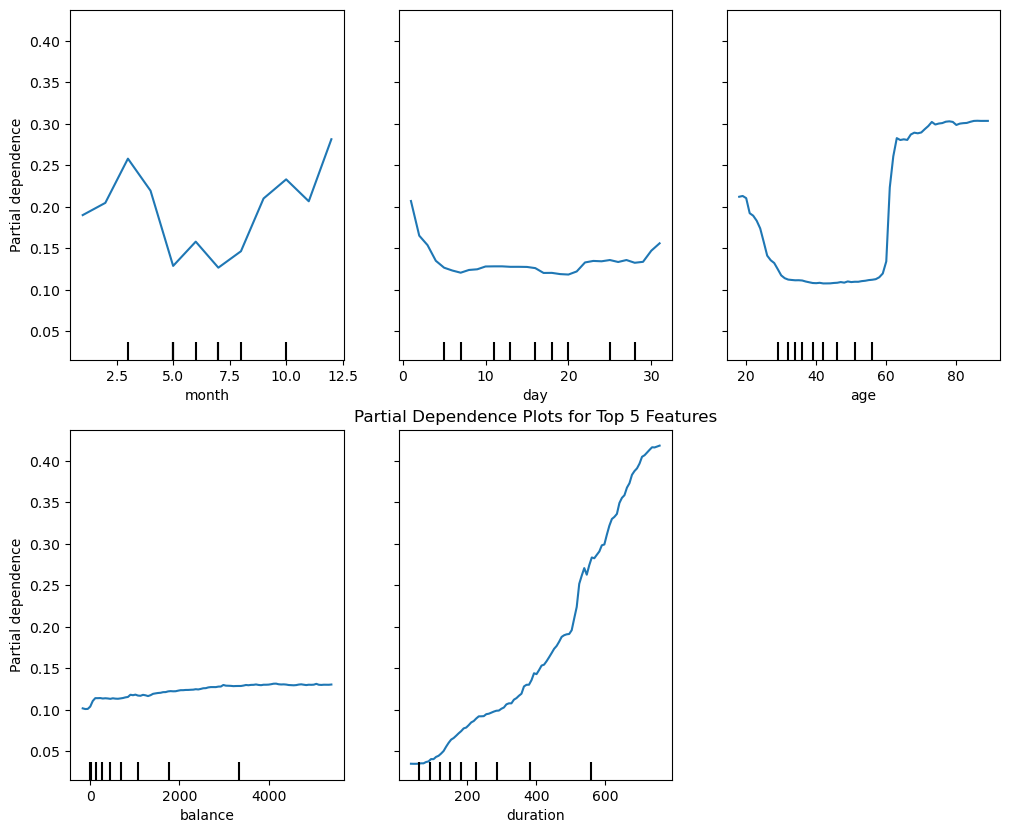

In [23]:
# Top 5 features
top5_indices = np.argsort(importances)[-5:]
top_5_features = [X_train.columns[i] for i in top5_indices]

# Print top 5 features
print(f'Top 5 features: {top_5_features}')

# Plot the partial dependence for these top 5 features
fig, ax = plt.subplots(figsize=(12, 10))
PartialDependenceDisplay.from_estimator(
    rf_optimal,
    X_test,
    features=top5_indices,
    feature_names=X_train.columns.tolist(),
    ax=ax
)
plt.title('Partial Dependence Plots for Top 5 Features')
plt.show()